<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

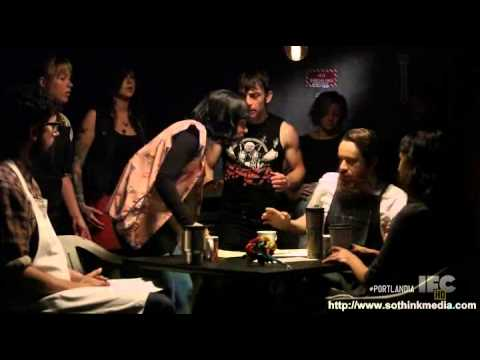

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'D:\\Lambda\\Repos\\Unit4Repo\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [117]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [118]:
# imports

# Base
from collections import Counter
import re

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

In [119]:
def datesplitter(text):
    '''takes the date off the beginning of the review, returns it.'''
    stripped = text.strip(' ')
    dateitem = stripped.split(' ')[0]
    return dateitem

def cleaner(text):
    '''cleans the review text.'''
    stripped = text.strip(' ')
    review = ' '.join(stripped.split(' ')[1:])
    lowered = review.lower()
    dechecked = re.sub(r'(\d+ check-ins?)', '', lowered)
    cleaned = re.sub(r'[^a-zA-Z ^0-9]', '', dechecked)
    despaced = cleaned.strip(' ')
    return despaced

tokenizer = Tokenizer(nlp.vocab)

def lemmatize(text):
    '''returns spaCy lemmas for a given text'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [120]:
# add a date column
shops['review_date'] = shops['full_review_text'].apply(datesplitter)

# add a check-in column
shops['check-ins'] = shops['full_review_text'].str.extract(r"((\d+) check-ins?)")[1].astype('float').fillna(0)

# clean the review text
shops['clean_review_text'] = shops['full_review_text'].apply(cleaner)

# remove leading/trailing spaces from shop names
shops['coffee_shop_name'] = shops['coffee_shop_name'].apply(lambda x: x.strip(' '))

#remove ' star rating' from ratings
shops['star_rating'] = shops['star_rating'].apply(lambda x: int(x.strip('.0 star rating')))

In [121]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,check-ins,clean_review_text
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,11/25/2016,1.0,love love loved the atmosphere every corner of...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,12/2/2016,0.0,listed in date night austin ambiance in austin...
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,11/30/2016,1.0,listed in brunch spots i loved the eclectic an...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,11/25/2016,0.0,very cool decor good drinks nice seating howe...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,12/3/2016,1.0,they are located within the northcross mall sh...


In [122]:
custom_list = [' ','coffee','place']

In [123]:
# Wrap it all in a function
def lemmatize(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON') and (token.text not in custom_list):
            lemmas.append(token.lemma_)
    
    return lemmas

In [124]:
shops['lemmas'] = shops['clean_review_text'].apply(lemmatize)

In [125]:
shops['lemmas'].head()

0    [love, love, love, atmosphere, corner, shop, s...
1    [list, date, night, austin, ambiance, austin, ...
2    [list, brunch, spot, love, eclectic, homey, pl...
3    [cool, decor, good, drink, nice, seating, over...
4    [locate, northcross, mall, shopping, center, f...
Name: lemmas, dtype: object

In [126]:
from collections import Counter
 
word_counts = Counter()

shops['lemmas'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('good', 5405),
 ('not', 5175),
 ('great', 3946),
 ('like', 3350),
 ('come', 2632),
 ('love', 2374),
 ('time', 2374),
 ('drink', 2319),
 ('austin', 2300),
 ('shop', 2200)]

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [127]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [134]:
# overall count
wc_overall = count(shops['lemmas'])
wc_overall.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
142,good,3601,5405,1.0,0.015576,0.015576,0.472820
109,not,3055,5175,2.0,0.014913,0.030490,0.401129
75,great,2853,3946,3.0,0.011372,0.041861,0.374606
139,like,2260,3350,4.0,0.009654,0.051516,0.296744
373,come,1931,2632,5.0,0.007585,0.059101,0.253545


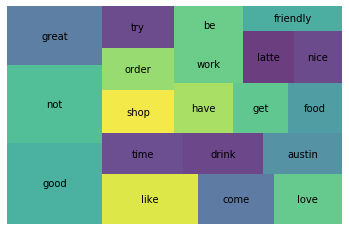

In [155]:
# plot overall
wc_overall_top20 = wc_overall[wc_overall['rank'] <= 20]

squarify.plot(sizes=wc_overall_top20['pct_total'], label=wc_overall_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [135]:
wc_bad = count(shops[(shops['star_rating'] <= 3)]['lemmas'])
wc_bad.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
120,not,868,1706,1.0,0.022094,0.022094,0.588076
12,good,649,1002,2.0,0.012976,0.035070,0.439702
9,like,592,936,3.0,0.012122,0.047192,0.401084
156,order,435,767,4.0,0.009933,0.057125,0.294715
50,come,452,650,5.0,0.008418,0.065543,0.306233


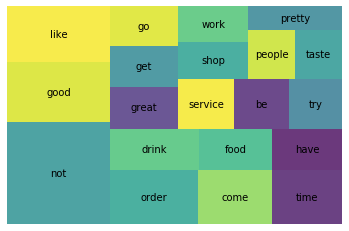

In [157]:
# plot bad
wc_bad_top20 = wc_bad[wc_bad['rank'] <= 20]

squarify.plot(sizes=wc_bad_top20['pct_total'], label=wc_bad_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [136]:
wc_good = count(shops[(shops['star_rating'] >= 4)]['lemmas'])
wc_good.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
176,good,2952,4403,1.0,0.016320,0.016320,0.480782
75,great,2505,3474,2.0,0.012877,0.029197,0.407980
109,not,2187,3469,3.0,0.012858,0.042056,0.356189
173,like,1668,2414,4.0,0.008948,0.051004,0.271661
21,love,1608,2120,5.0,0.007858,0.058862,0.261889


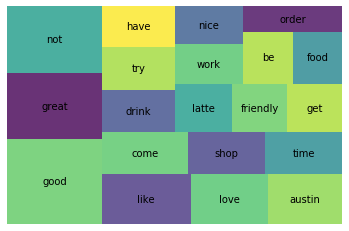

In [158]:
# plot good
wc_good_top20 = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_good_top20['pct_total'], label=wc_good_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [150]:
wc_diffs = wc_good[['word', 'appears_in_pct']].copy()
wc_diffs['appears_in_pct_good'] = wc_diffs['appears_in_pct']
wc_diffs.drop(['appears_in_pct'], axis=1, inplace=True)

wc_diffs = wc_diffs.merge(wc_bad[['word', 'appears_in_pct']], on='word', how='outer')
wc_diffs['appears_in_pct_bad'] = wc_diffs['appears_in_pct']
wc_diffs.drop(['appears_in_pct'], axis=1, inplace=True)
wc_diffs['pct_dff'] = wc_diffs['appears_in_pct_good'] - wc_diffs['appears_in_pct_bad']
wc_diffs['pct_dff_abs'] = abs(wc_diffs['pct_dff'])


In [154]:
wc_diffs.sort_values('pct_dff_abs',ascending=False).head(10)

,word,appears_in_pct_good,appears_in_pct_bad,pct_dff,pct_dff_abs
2,not,0.356189,0.588076,-0.231887,0.231887
1,great,0.407980,0.235772,0.172208,0.172208
20,delicious,0.191857,0.056233,0.135624,0.135624
3,like,0.271661,0.401084,-0.129423,0.129423
19,order,0.166612,0.294715,-0.128103,0.128103
4,love,0.261889,0.142276,0.119613,0.119613
13,friendly,0.231107,0.122629,0.108479,0.108479
141,ask,0.050651,0.149051,-0.098400,0.098400
33,service,0.140391,0.234417,-0.094026,0.094026
211,bad,0.037785,0.129404,-0.091619,0.091619


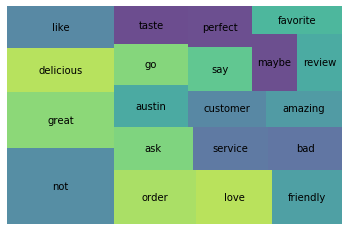

In [160]:
wc_diffs_top20 = wc_diffs.sort_values('pct_dff_abs',ascending=False).head(20)

squarify.plot(sizes=wc_diffs_top20['pct_dff_abs'], label=wc_diffs_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

